In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
train_df = pd.read_csv(r"C:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance\data\processed_train.csv")
test_df = pd.read_csv(r"C:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance\data\processed_test.csv")

# Replace any non-numeric entries or invalid values
train_df = train_df.apply(pd.to_numeric, errors='coerce')
test_df = test_df.apply(pd.to_numeric, errors='coerce')

# Fill NaNs and infinities with column means
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)
train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())

X_train = train_df.drop("RUL", axis=1).values
y_train = train_df["RUL"].values
X_test = test_df.drop("RUL", axis=1).values
y_test = test_df["RUL"].values

print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())
print("Range of X_train:", np.nanmin(X_train), "to", np.nanmax(X_train))
print("Range of y_train:", np.nanmin(y_train), "to", np.nanmax(y_train))


NaNs in X_train: 0
NaNs in y_train: 0
Range of X_train: 0.0 to 362.0
Range of y_train: 0 to 361


In [20]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM [samples, timesteps, features]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [21]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.5),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


c:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:

print("Checking training data:")
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())
print("Infs in X_train:", np.isinf(X_train).sum())
print("Infs in y_train:", np.isinf(y_train).sum())
print("X_train range:", np.min(X_train), "to", np.max(X_train))
print("y_train range:", np.min(y_train), "to", np.max(y_train))


Checking training data:
NaNs in X_train: 0
NaNs in y_train: 0
Infs in X_train: 0
Infs in y_train: 0
X_train range: 0.0 to 1.0
y_train range: 0 to 361


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Replace NaNs or Infs with 0 or column mean
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# OPTIONAL: If you used a DataFrame earlier, you can also do:
# X = pd.DataFrame(X).fillna(0).replace([np.inf, -np.inf], 0).values

# Normalize (scale between 0 and 1)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Also scale your target (important for LSTM stability)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape for LSTM [samples, timesteps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

print("Data cleaned and scaled successfully!")
print("Any NaNs left?", np.isnan(X_scaled).sum())


Data cleaned and scaled successfully!
Any NaNs left? 0


In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


loss, mae = model.evaluate(X_test, y_test)
print(f"\nFinal Model Evaluation — Loss: {loss:.4f}, MAE: {mae:.4f}")

Epoch 1/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 11901.3232 - mae: 87.1254 - val_loss: 8439.1240 - val_mae: 72.8145
Epoch 2/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7916.0615 - mae: 69.1659 - val_loss: 5905.1943 - val_mae: 61.3762
Epoch 3/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 6076.0649 - mae: 61.4311 - val_loss: 4789.6919 - val_mae: 56.6461
Epoch 4/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5326.6523 - mae: 58.5678 - val_loss: 4411.2642 - val_mae: 55.2799
Epoch 5/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5072.1299 - mae: 57.7753 - val_loss: 4321.9429 - val_mae: 55.1160
Epoch 6/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5048.2676 - mae: 58.0039 - val_loss: 4310.3140 - val_mae: 55.1864
Epoch 7/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5024.8818 - mae: 57.9786 - val_loss: 4310.9521 - val_mae: 55.2425
Epoch 8/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 5012.1592 - mae: 57.9532 - val_loss: 4311.3413 - v

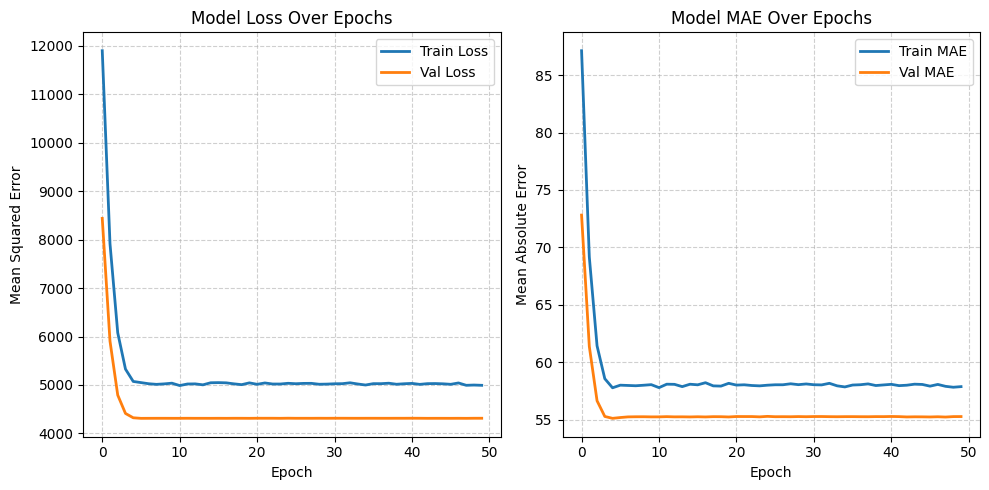

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [26]:
os.makedirs("models", exist_ok=True)
model.save("models/final_lstm_model.h5")
print("Final optimized model saved successfully!")


os.makedirs("results", exist_ok=True)
metrics_df = pd.DataFrame([{"loss": loss, "mae": mae}])
metrics_df.to_csv("results/final_model_performance.csv", index=False)
print("Final model performance saved.")

Final optimized model saved successfully!
Final model performance saved.


In [27]:
import os
import pandas as pd

# Ensure correct absolute path
base_dir = r"C:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance"
results_path = os.path.join(base_dir, "results")

os.makedirs(results_path, exist_ok=True)

# Save metrics CSV to the absolute path
metrics_df = pd.DataFrame([{"loss": loss, "mae": mae}])
metrics_df.to_csv(os.path.join(results_path, "final_model_performance.csv"), index=False)

print(f"✅ Final model performance saved at: {results_path}")


✅ Final model performance saved at: C:\Users\ADMIN\OneDrive\Desktop\predictive_maintenance\results
